### Import and read ###

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split, GridSearchCV 
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.ensemble import VotingClassifier

In [2]:
#Read in previously cleaned dataset
pd.set_option('display.max_columns', None)
clean_data = pd.read_csv('mc_FE.csv')
clean_data.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Days_Since_Customer,Fam_Size,Num_Accepted,MntTotal
0,2,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0,1,64,3865.086602,1,0,2252
1,2,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0,0,67,3315.086602,3,0,38
2,2,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,56,3514.086602,2,0,1202
3,2,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,37,3341.086602,3,0,64
4,4,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,40,3363.086602,3,0,595


In [3]:
#Remove the 'Response' column because it is the target of future predictive model
X, y = clean_data.drop('Response', axis=1).values, clean_data['Response'].values

#Creates a column transformer that sends 'Education' to be encoded and rest scaled
ct = ColumnTransformer([
    ('catagoric', OneHotEncoder(), [0]),
    ('numeric', StandardScaler(), list(range(1, len(X.T))))
])

#Sends the data through the column transformer
X_transformed = ct.fit_transform(X)
print('Preprocessed Data:')
print(X_transformed[0])

Preprocessed Data:
[ 0.          0.          1.          0.          0.          0.23569584
  0.30703926  0.98378127  1.55157698  1.67970233  2.46214705  1.4765001
  0.84320691  0.34941394  1.40930394  2.51089024 -0.55078479  0.69390374
 -0.09728167  0.98534473  1.53118494 -1.75911463 -0.43903713  1.4669731 ]


### Split the dataset and balance classes ###

In [4]:
#Split into train (75%) and test (25%)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.25, random_state=8)

#Split the test set into 2 sets; 1 for test, 1 for validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.7, random_state=8)

#Display length of each set
print('Length of Each Dataset:')
print('Training Set:', len(X_train))
print('Validation Set:', len(X_val))
print('Test Set:', len(X_test))

Length of Each Dataset:
Training Set: 1680
Validation Set: 168
Test Set: 392


In [5]:
#Balance the training data set using SMOTE
#create the SMOTE object
sm = SMOTE(random_state=8)

#create new training set with SMOTE object
X_bal, y_bal = sm.fit_resample(X_train, y_train)

#Displays perccent of each class
print('Initial Training Set')
print('Percent "Responded":', y_train.sum()/len(y_train))
print('Balanced Training Set')
print('Percent "Responded":', y_bal.sum()/len(y_bal))

Initial Training Set
Percent "Responded": 0.14702380952380953
Balanced Training Set
Percent "Responded": 0.5


#### Create Models

For the following models, recall will be a very important metric. This is because we would rather have more False Positives (customers who will not respond to the marketing but was targeted anyway) than False Negatives (customers who would have responded to the add but were not targeted). For these reasons, a balance must be struck between accuracy of the model and the recall of the model.

#### Logistic Regression

In [6]:
#Create a Logistic Regression Model
#Params to test in grid search
lr_params = {'solver': ['liblinear'], 'penalty': ['l1'], 'C': [1.0, 0.5, 0.25]}

#grid search
lr_grid = GridSearchCV(LogisticRegression(), lr_params, cv=3, scoring='recall')

#fit the grid to the training set
lr_grid.fit(X_bal, y_bal)

#ID the best model
lr = lr_grid.best_estimator_

#Display Best Parameters
print('Best Parameters:', lr_grid.best_params_)

#Display the metrics for the validation set
lr_preds = lr.predict(X_val)
lr_val_acc = accuracy_score(y_val, lr_preds)
lr_val_rec = recall_score(y_val, lr_preds)
print('Logistic Regression Model Accuracy:', lr_val_acc)
print('Logistic Regression Model Recall:', lr_val_rec)

Best Parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Model Accuracy: 0.7678571428571429
Logistic Regression Model Recall: 0.7777777777777778


#### SUpport Vector Machine

In [7]:
#Create a Support Vector machine
#Params to test in grid search
svm_params = {'kernel': ['poly', 'rbf'], 'C': [1.0, 0.5, 0.25], 'gamma': ['scale', 'auto']}

#grid search
svm_grid = GridSearchCV(SVC(), svm_params, cv=3, scoring='recall')

#fit the grid to the training set
svm_grid.fit(X_bal, y_bal)

#ID the best model
svm = svm_grid.best_estimator_

#Display Best Parameters
print('Best Parameters:', svm_grid.best_params_)

#Display the metrics for the validation set
svm_preds = svm.predict(X_val)
svm_val_acc = accuracy_score(y_val, svm_preds)
svm_val_rec = recall_score(y_val, svm_preds)
print('Support Vector Machine Accuracy:', svm_val_acc)
print('Support Vector Machine Recall:', svm_val_rec)

Best Parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Support Vector Machine Accuracy: 0.8452380952380952
Support Vector Machine Recall: 0.6296296296296297


#### KNN

In [8]:
#Create a knn model
#Params to test in grid search
knn_params = {'n_neighbors': [7, 9, 11], 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
             'weights': ['uniform', 'distance']}

#grid search
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, scoring='recall')

#fit the grid to the training set
knn_grid.fit(X_bal, y_bal)

#ID the best model
knn = knn_grid.best_estimator_

#Display Best Parameters
print('Best Parameters:', knn_grid.best_params_)

#Display the metrics for the validation set
knn_preds = knn.predict(X_val)
knn_val_acc = accuracy_score(y_val, knn_preds)
knn_val_rec = recall_score(y_val, knn_preds)
print('K Nearest Neighbors Accuracy:', knn_val_acc)
print('K Nearest Neighbors Recall:', knn_val_rec)

Best Parameters: {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'distance'}
K Nearest Neighbors Accuracy: 0.7619047619047619
K Nearest Neighbors Recall: 0.7407407407407407


#### Naive Bayes

In [9]:
#Create a naive bayes model
nb = GaussianNB()

#fit the model to the training set
nb.fit(X_bal, y_bal)

#Display the metrics for the validation set
nb_preds = nb.predict(X_val)
nb_val_acc = accuracy_score(y_val, nb_preds)
nb_val_rec = recall_score(y_val, nb_preds)
print('Naive Bayes Accuracy:', nb_val_acc)
print('Naive Bayes Machine Recall:', nb_val_rec)

Naive Bayes Accuracy: 0.6488095238095238
Naive Bayes Machine Recall: 0.5555555555555556


#### Gradient Boosting Tree

In [10]:
#Create a xgboost model
#Params to test in grid search
xgb_params = {'n_estimators': [240, 250, 260], 'max_depth': [15, 16, 17],
             'colsample_bytree': [0.6, 0.7, 0.8, 1.0]}

#grid search
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, verbosity=0), xgb_params, cv=3, 
                        scoring='recall')

#fit the grid to the training set
xgb_grid.fit(X_bal, y_bal)

#ID the best model
xgb = xgb_grid.best_estimator_

#Display Best Parameters
print('Best Parameters:', xgb_grid.best_params_)

#Display the metrics for the validation set
xgb_preds = xgb.predict(X_val)
xgb_val_acc = accuracy_score(y_val, xgb_preds)
xgb_val_rec = recall_score(y_val, xgb_preds)
print('Gradient Boosting Tree Accuracy:', xgb_val_acc)
print('Gradient Boosting Tree Recall:', xgb_val_rec)

c:\Users\samro\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\samro\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\samro\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\samro\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\samro\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encode

Best Parameters: {'colsample_bytree': 0.6, 'max_depth': 15, 'n_estimators': 250}
Gradient Boosting Tree Accuracy: 0.8690476190476191
Gradient Boosting Tree Recall: 0.4444444444444444


## Creating an ensemble of models

In [11]:
#Create ensemble model of all the other models
#list of models
models = [('logistic_regression', lr), ('support vector machine', svm), 
        ('knn', knn), ('naive_bayes', nb), ('gradient_boost', xgb)]

#Combine models
ensemble_model = VotingClassifier(estimators=models)

#fit the model on the training set
ensemble_model.fit(X_bal, y_bal)

#Display the metrics for the validation set
ensemble_preds = ensemble_model.predict(X_val)
ensemble_val_acc = accuracy_score(y_val, ensemble_preds)
ensemble_val_rec = recall_score(y_val, ensemble_preds)
print('Ensemble Model Accuracy:', ensemble_val_acc)
print('Ensemble Model Recall:', ensemble_val_rec)

c:\Users\samro\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Ensemble Model Accuracy: 0.8452380952380952
Ensemble Model Recall: 0.7037037037037037


In [12]:
#Display the metrics of the Ensemble model on the test set
test_preds = ensemble_model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)
test_rec = recall_score(y_test, test_preds)
print('Test Set Metrics')
print('Ensemble Model Accuracy:', test_acc)
print('Ensemble Model Recall:', test_rec)

Test Set Metrics
Ensemble Model Accuracy: 0.8724489795918368
Ensemble Model Recall: 0.8833333333333333


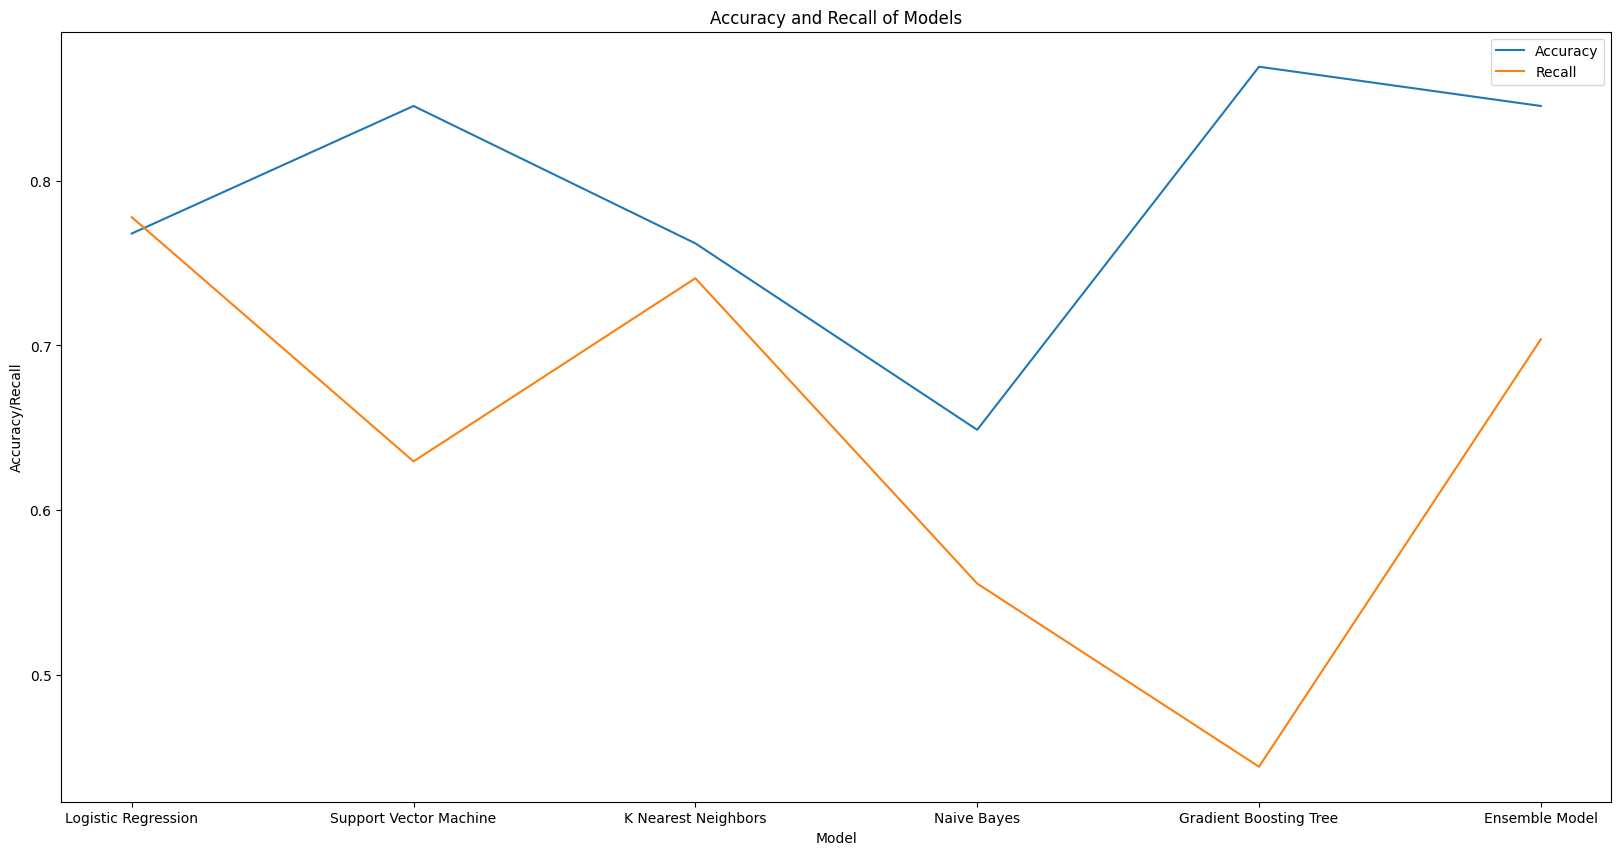

In [13]:
# visualise accuracy and recall for each model using line plot and increase the size of the plot
plt.figure(figsize=(20, 10))
plt.plot(['Logistic Regression', 'Support Vector Machine', 'K Nearest Neighbors', 'Naive Bayes', 'Gradient Boosting Tree', 'Ensemble Model'], [lr_val_acc, svm_val_acc, knn_val_acc, nb_val_acc, xgb_val_acc, ensemble_val_acc], label='Accuracy')
plt.plot(['Logistic Regression', 'Support Vector Machine', 'K Nearest Neighbors', 'Naive Bayes', 'Gradient Boosting Tree', 'Ensemble Model'], [lr_val_rec, svm_val_rec, knn_val_rec, nb_val_rec, xgb_val_rec, ensemble_val_rec], label='Recall')
plt.title('Accuracy and Recall of Models')
plt.xlabel('Model')
plt.ylabel('Accuracy/Recall')
plt.legend()
plt.show()


In [14]:
import joblib

# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(ensemble_model, filename)



['finalized_model.sav']

In [16]:
import pickle

# save the pickle file
pickle.dump(ensemble_model, open('model.pkl', 'wb'))
